In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt


/var/folders/f_/xfklpqfj6kjg8yr6l1byph0h0000gn/T/ipykernel_4270/403785306.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
# Use os.listdir() to get all the names within the folder
all_names = os.listdir('results')

# Filter out the names that correspond to folders
cities = [name for name in all_names if os.path.isdir(os.path.join('results', name))]

In [3]:
def plot_unavailable(all_cities_results):
    grouped = all_cities_results.groupby(
        ["highway", "city"]
        ).agg(
            {"total_null": "sum", 
             "proportion_null": "sum"})
    
    grouped2 = grouped.groupby("highway").agg({"total_null": "sum"})

    # Sort the grouped DataFrame by 'total_null' column in descending order and select the top 5 rows
    top_5_highways = list(grouped2.nlargest(5, 'total_null').index)

    grouped = grouped.loc[top_5_highways]

    grouped = grouped.reset_index()

    # Create a bar plot for the top 5 highway types
    bar1 = sns.barplot(data=grouped, x='highway', y='proportion_null', hue='city', palette="magma")

    # Create custom legend handles and labels for bar1
    handles1, labels1 = bar1.get_legend_handles_labels()
    # Add the legends outside of the plot
    plt.legend(handles1, labels1, title='City', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Set labels and title
    plt.xlabel('Highway Types')
    plt.ylabel('Proportion of Missing Images')
    plt.title('Highway Types with Most Missing Images')
    
    # Rotate x-axis labels if needed
    plt.xticks(rotation=90)

    # Set the maximum value for the y-axis
    plt.ylim(0, 1)

    # Show the plot
    plt.show()

In [4]:
def get_unavailable_and_unsuitable(intersection, city):
    grouped = intersection.groupby(['road_index_x', 'highway']).agg({
        'GVI': lambda x: x.isnull().sum(),            # Count of null values in 'GVI'
    }).reset_index()

    grouped.columns = ['road_index', 'highway', 'total_null']
    
    count = grouped.groupby('highway').agg({
        'total_null': 'sum',
    }).sort_values('total_null', ascending=False)

    count['city'] = city

    count['proportion_null'] = count["total_null"] / len(intersection)
    
    return count

In [5]:
# Create an empty DataFrame to store aggregated results from all cities
all_cities_results = pd.DataFrame()
results = {}

for city in cities:
    dir_path = os.path.join("results", city)

    # Load roads layer
    roads_path = os.path.join(dir_path, "gvi", "gvi-streets.gpkg")
    roads = gpd.read_file(roads_path, layer="gvi-streets")

    # Load points with gvi layer
    points_path = os.path.join(dir_path, "gvi", "gvi-points.gpkg")
    points = gpd.read_file(points_path, layer="gvi-points", crs=4326)
    points.to_crs(crs=roads.crs, inplace=True)

    # Load points with roads layer
    points_road_path = os.path.join(dir_path, "points", "points.gpkg")
    points_road = gpd.read_file(points_road_path, layer="points", crs=4326)
    points_road.to_crs(crs=roads.crs, inplace=True)

    points_road = points_road.merge(points, on="id")

    # Merge the previous dataframe with the roads dataframe
    intersection = points_road.merge(roads, left_on="road_index", right_on="index")

    intersection = intersection[["id", "image_id", "distance", "is_panoramic_x", "road_index_x", "geometry_x", "GVI", "length", "highway"]]

    results[city] = intersection

    count = get_unavailable_and_unsuitable(intersection, city)

    # Append the results of each city to the all_cities_results DataFrame
    all_cities_results = pd.concat([all_cities_results, count])

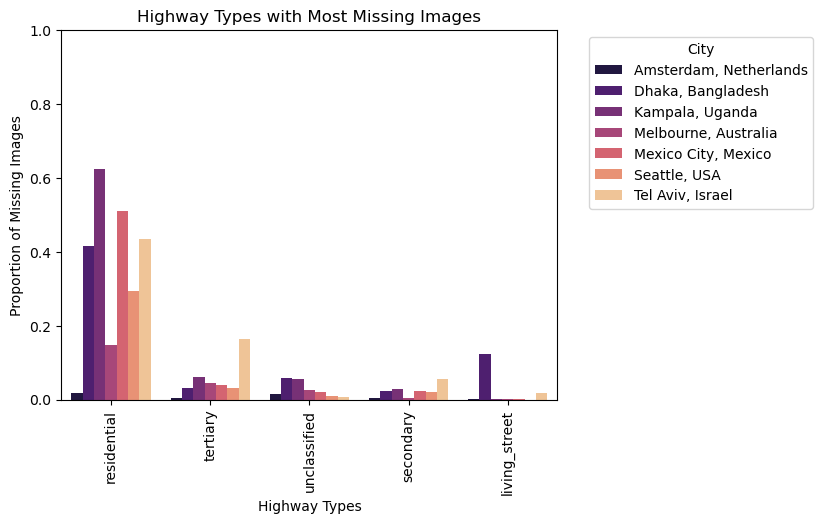

In [6]:
plot_unavailable(all_cities_results)

### Missing images

In [7]:
# Table with number null images

# Create an empty DataFrame to store the results
result_table = pd.DataFrame(columns=['unavailable', 'unsuitable', 'total_null', 'percentage_null', 'total_points'])

for city in cities:
    df = results[city]

    unavailable = df[df["image_id"] == ""].count()[0]
    unsuitable = df[(df["GVI"].isnull()) & (df["image_id"]!="")].count()[0]
    total_null = df[df["GVI"].isnull()].count()[0]
    total = df.count()[0]
    percentage_null = total_null / total

    result_table.loc[city] = [unavailable, unsuitable, total_null, percentage_null, total]

In [8]:
result_table.sort_values(by="percentage_null")

,unavailable,unsuitable,total_null,percentage_null,total_points
"Amsterdam, Netherlands",494.0,1632.0,2126.0,0.055172,38534.0
"Melbourne, Australia",1691.0,951.0,2642.0,0.254430,10384.0
"Seattle, USA",14770.0,8127.0,22897.0,0.370496,61801.0
"Mexico City, Mexico",170830.0,21118.0,191948.0,0.621545,308824.0
"Dhaka, Bangladesh",51474.0,5111.0,56585.0,0.685447,82552.0
"Tel Aviv, Israel",10591.0,1373.0,11964.0,0.707259,16916.0
"Kampala, Uganda",26751.0,6373.0,33124.0,0.809620,40913.0


### Panoramic images

In [9]:
# Create an empty DataFrame to store the results
result_table = pd.DataFrame(columns=['Panoramic Images', 'Total Images', "Proportion"])

for city in cities:
    df = results[city]

    is_panoramic = df[df["is_panoramic_x"]].count()[0]
    total = df[df["image_id"] != ""].count()[0]

    result_table.loc[city] = [is_panoramic, total, is_panoramic/total]

In [10]:
result_table.sort_values(by="Proportion")

,Panoramic Images,Total Images,Proportion
"Dhaka, Bangladesh",0.0,31078.0,0.000000
"Mexico City, Mexico",689.0,137994.0,0.004993
"Melbourne, Australia",52.0,8693.0,0.005982
"Kampala, Uganda",197.0,14162.0,0.013910
"Tel Aviv, Israel",128.0,6325.0,0.020237
"Seattle, USA",7069.0,47031.0,0.150305
"Amsterdam, Netherlands",32216.0,38040.0,0.846898


### Adjusted Availability Score

In [11]:
# Create an empty DataFrame to store the results
result_table = pd.DataFrame(columns=['GVI Points', 'Road Length', 'Total Sample', 'Availability Score', 'Adjusted Availability Score'])

for city in cities:
    df = results[city]

    gvi_points = df[~df["GVI"].isnull()].count()[0]
    road_length = df["length"].sum() / 1000
    total = df.count()[0]

    result_table.loc[city] = [gvi_points, road_length, total, gvi_points/total, (gvi_points  * road_length)/total]

In [12]:
result_table.sort_values(by="Availability Score")

,GVI Points,Road Length,Total Sample,Availability Score,Adjusted Availability Score
"Kampala, Uganda",7789.0,7903.787527,40913.0,0.190380,1504.719797
"Tel Aviv, Israel",4952.0,3149.644784,16916.0,0.292741,922.028906
"Dhaka, Bangladesh",25967.0,18044.102487,82552.0,0.314553,5675.831104
"Mexico City, Mexico",116876.0,70205.492611,308824.0,0.378455,26569.622680
"Seattle, USA",38904.0,13439.004521,61801.0,0.629504,8459.912168
"Melbourne, Australia",7742.0,2221.459293,10384.0,0.745570,1656.253645
"Amsterdam, Netherlands",36408.0,11218.417615,38534.0,0.944828,10599.474452
